<a href="https://colab.research.google.com/github/celelunar/Text-Clustering-and-Topic-Extraction-on-BSI-Complaints/blob/main/Text%20Clustering%20and%20Topic%20Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Diva Nabila Henryka

ID: 2501975620

## Install and Import Libraries

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.7 MB/s eta 0:00:00


In [ ]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
from pprint import pprint
import pandas as pd
import numpy as np

import re

import nltk
from nltk import punkt
from nltk import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import gensim
from gensim import corpora, models
from gensim.models import LsiModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import json

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Text Preprocessing

### Read the Dataset
The data is first uploaded into the Google Colaboratory File System before it can be read by the pandas library function `pd.read_csv()`

In [ ]:
df = pd.read_csv('data_2D.csv')
df.head()

Unnamed: 0  index                                                URL  \
0           0   1412  https://twitter.com/oksihen/status/16584282698...   
1           1  23337  https://twitter.com/reixyynx/status/1655911656...   
2           2  23099  https://twitter.com/sheyappe/status/1655924302...   
3           3   5691  https://twitter.com/tfouive/status/16575732480...   
4           4  16823  https://twitter.com/itshaeyoz/status/165648391...   

                        Date  \
0  2023-05-16 11:04:46+00:00   
1  2023-05-09 12:24:38+00:00   
2  2023-05-09 13:14:54+00:00   
3  2023-05-14 02:27:13+00:00   
4  2023-05-11 02:18:35+00:00   

                                               Tweet                   ID  \
0  @__nsch @bankbsi_id @Bittersweutz kak mendinga...  1658428269849608192   
1  @Adelyaaav @med_faqih08 @bankbsi_id sore ini p...  1655911656407580672   
2  @SeokjinRie @bankbsi_id dih ternyata transfer ...  1655924302917804033   
3  @bankbsi_id kalo ambil duitnya langsung ke ban...  1657573248035586048   
4  @bankbsi_id min ayo dong kasi tau info ke nasa...  1656483914373005312   

    Username  Replies  Reetweets  Likes  Quotes       conversationId Language  \
0    oksihen        1          0      0       0  1655777758180708355       in   
1   reixyynx        0          0      0       0  1655781242166710273       in   
2   sheyappe        1          0      0       0  1655909697399177217       in   
3    tfouive        1          0      0       0  1657346196548239360       in   
4  itshaeyoz        1          0      2       0  1655777758180708355       in   

  Links Media  Retweeted Tweet  Bookmarks  
0   NaN   NaN              NaN          0  
1   NaN   NaN              NaN          0  
2   NaN   NaN              NaN          0  
3   NaN   NaN              NaN          0  
4   NaN   NaN              NaN          0

### Data Cleaning
Lowering the text data and removing non-alphanumeric characters.

In [ ]:
def cleaning(text):
  # to lower case
  text_clean = [i.lower() for i in text]

  # to remove emoji patterns
  text_clean = [re.sub(r'\\x[\da-fA-F]{2}', '', i) for i in text_clean]

  # to remove username tags
  text_clean = [re.sub(r'@\w+', '', i) for i in text_clean]

  # to remove URLs
  text_clean = [re.sub(r'http\S+', '', i) for i in text_clean]

  # to remove numbers
  text_clean = [re.sub(r"\d+", "",i ) for i in text_clean]

  # to remove symbols
  text_clean = [re.sub(r'[^\w\s]', ' ', i) for i in text_clean]

  # to remove non-ascii characters
  text_clean = [re.sub(r'[^\x00-\x7F]+', '', i) for i in text_clean]

  # to remove extra spaces
  text_clean = [re.sub(r'\s+', ' ', i) for i in text_clean]

  # to remove leading or trailing whitespaces
  text_clean = [i.strip() for i in text_clean]

  return text_clean

In [ ]:
cleaned = cleaning(df['Tweet'])
df.insert(5, 'Cleaned', cleaned)
df.head()

Unnamed: 0  index                                                URL  \
0           0   1412  https://twitter.com/oksihen/status/16584282698...   
1           1  23337  https://twitter.com/reixyynx/status/1655911656...   
2           2  23099  https://twitter.com/sheyappe/status/1655924302...   
3           3   5691  https://twitter.com/tfouive/status/16575732480...   
4           4  16823  https://twitter.com/itshaeyoz/status/165648391...   

                        Date  \
0  2023-05-16 11:04:46+00:00   
1  2023-05-09 12:24:38+00:00   
2  2023-05-09 13:14:54+00:00   
3  2023-05-14 02:27:13+00:00   
4  2023-05-11 02:18:35+00:00   

                                               Tweet  \
0  @__nsch @bankbsi_id @Bittersweutz kak mendinga...   
1  @Adelyaaav @med_faqih08 @bankbsi_id sore ini p...   
2  @SeokjinRie @bankbsi_id dih ternyata transfer ...   
3  @bankbsi_id kalo ambil duitnya langsung ke ban...   
4  @bankbsi_id min ayo dong kasi tau info ke nasa...   

                                             Cleaned                   ID  \
0           kak mendingan hubungi aja call centernya  1658428269849608192   
1                                  sore ini pun sama  1655911656407580672   
2  dih ternyata transfer ke bank lain masih belum...  1655924302917804033   
3  kalo ambil duitnya langsung ke bank bisa ga si...  1657573248035586048   
4  min ayo dong kasi tau info ke nasabahnya udh s...  1656483914373005312   

    Username  Replies  Reetweets  Likes  Quotes       conversationId Language  \
0    oksihen        1          0      0       0  1655777758180708355       in   
1   reixyynx        0          0      0       0  1655781242166710273       in   
2   sheyappe        1          0      0       0  1655909697399177217       in   
3    tfouive        1          0      0       0  1657346196548239360       in   
4  itshaeyoz        1          0      2       0  1655777758180708355       in   

  Links Media  Retweeted Tweet  Bookmarks  
0   NaN   NaN              NaN          0  
1   NaN   NaN              NaN          0  
2   NaN   NaN              NaN          0  
3   NaN   NaN              NaN          0  
4   NaN   NaN              NaN          0

### Data Splitting
Split the data into 2 sets, Training (80%) and Testing (20%).

In [ ]:
x_train, x_test = train_test_split(df['Cleaned'], test_size=0.2, random_state=42)

In [ ]:
print(f'Train size: {len(x_train)}')
print(f'Test size: {len(x_test)}')

Train size: 4880
Test size: 1221


### Tokenization, Stemming, Stopwords Filtering and Slang Words Normalization
I'll be using stemmer and stopwords from `Sastrawi` library which is designed for Indonesian nlp tasks. Since the dataset contains many slang words, I'll also be employing a pre-made dictionary to normalize those slang words.

Link to dictionary:
https://github.com/louisowen6/NLP_bahasa_resources/blob/master/combined_slang_words.txt

In [ ]:
def load_slang_dict(file_path):
  with open(file_path, 'r') as file:
      slang_dict = json.load(file)
  return slang_dict

In [ ]:
slang_dict = load_slang_dict('combined_slang_words.txt')

In [ ]:
stop_factory = StopWordRemoverFactory()
more_stopword = ["iya", "kakak"]
stopwords = stop_factory.get_stop_words()+more_stopword

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    token = token.lower().strip()

    if token in slang_dict:
      token = slang_dict[token]

    token = stemmer.stem(token)

    if token not in stopwords:
      result.append(token)

  return ' '.join(result)

### WordCloud Preparation

In [ ]:
list_colors = ["#f94144", "#f8961e", "#ffe66d", "#43aa8b", "#77c3ec", "#3f37c9", "#7209b7", "#ef6292"]

wc = WordCloud(
      background_color = "white",
      max_words = 10,
      max_font_size = 300,
      prefer_horizontal = 1.0,
      color_func=lambda *args, **kwargs: list_colors[i],
)

## K-Means Clustering

### TF-IDF Vectorization
To prepare the training data for K-Means clustering by converting it into a numerical format that highlights the importance and rarity of words within documents and across the entire dataset.

In [ ]:
preprocessed_train = [preprocess(text) for text in x_train]

In [ ]:
vectorizer = TfidfVectorizer()
data_kmeans = vectorizer.fit_transform(preprocessed_train)
data_kmeans_tfidf = pd.DataFrame(data_kmeans.toarray(),
                          columns = vectorizer.get_feature_names_out())
data_kmeans_tfidf.head()

aaaa  aaaaahhh  aal  aamiin  abal  abang  abc  abis  abistu  academia  ...  \
0   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
1   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
2   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
3   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
4   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   

   zholimin  zionis  ziva  zolim  zona  zonaba  zonauang  zuma  zzz  zzzz  
0       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
1       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
2       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
3       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
4       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  

[5 rows x 6005 columns]

### Silhouette Score
Helps determine the optimal number of clusters for K-Means clustering by evaluating the Silhouette score for various k values (2-8).
The Silhouette score indicates how well data points are separated into clusters, with higher scores signifying better separation.



In [ ]:
scores = []
k = range(2, 9)

for i in k:
  kmeanModel = KMeans(n_clusters = i, random_state = 42)
  labels = kmeanModel.fit_predict(data_kmeans_tfidf)

  print(f'Silhouette Score for {i} clusters: {silhouette_score(data_kmeans_tfidf, labels)}')
  scores.append(silhouette_score(data_kmeans_tfidf, labels))

Silhouette Score for 2 clusters: 0.009863654813010325
Silhouette Score for 3 clusters: 0.010995222352442055
Silhouette Score for 4 clusters: 0.012328770675037595
Silhouette Score for 5 clusters: 0.014459116409306833
Silhouette Score for 6 clusters: 0.01528809658371659
Silhouette Score for 7 clusters: 0.015972123776298038
Silhouette Score for 8 clusters: 0.017515191829332134


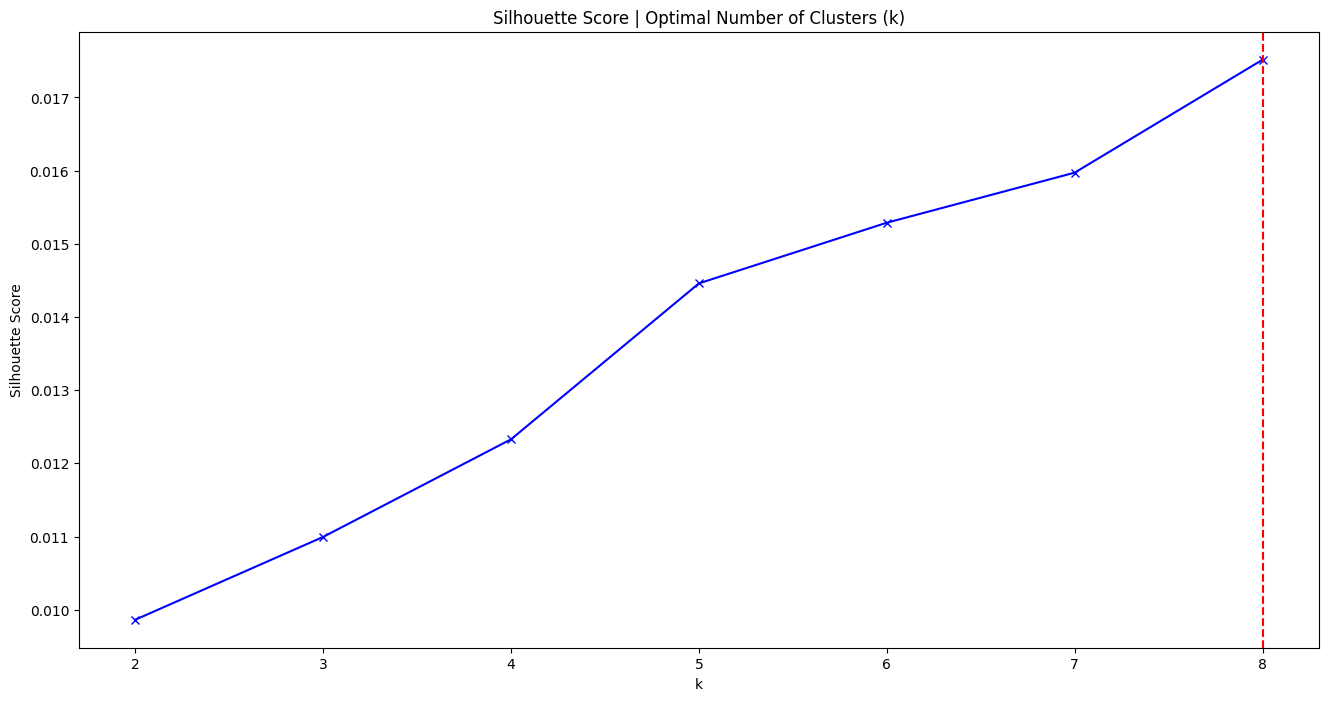

In [ ]:
max_silhouette_idx = scores.index(max(scores))

plt.figure(figsize = (16, 8))
plt.plot(k, scores, 'bx-')
plt.axvline(x=k[max_silhouette_idx],
            color='red',
            linestyle='--',
            label='Max Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score | Optimal Number of Clusters (k)')
plt.show()

From both output above, it can be seen that k = 8 achieve the highest silhouette scores. Which means we will be using k = 8 from here on out.

### K-Means Modelling
Model building with:
- `n_clusters = 8` based on the optimal number identified earlier.
- `max_iter = 100` which means the K-Means algorithm will iterate with maximum of 100 times to find suitable cluster centers.
- `n_init = 5` defines the number of times the K-Mean algorithm will be run with different initial cluster centers, 5 times in this case.

The model is then fitted into the TF-IDF vectorized data. During this process, the algorithm iteratively assigns data points to clusters, refines the cluster centers based on assigned points, and reassigns points until it converges (or reaches the maximum iterations).


In [ ]:
KMeansModel = KMeans(n_clusters = 8, max_iter = 100, n_init = 5)
KMeansModel.fit(data_kmeans_tfidf)

KMeans(max_iter=100, n_init=5)

This snippet creates a new column named "Cluster" in the `data_kmeans_tfidf DataFrame`. It then uses the trained K-Means model (`KMeansModel`) to predict the cluster label for each data point in the DataFrame and assigns those labels to the new "Cluster" column.

In [ ]:
data_kmeans_tfidf['Cluster'] = KMeansModel.predict(data_kmeans_tfidf)
data_kmeans_tfidf.head()

aaaa  aaaaahhh  aal  aamiin  abal  abang  abc  abis  abistu  academia  ...  \
0   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
1   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
2   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
3   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
4   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   

   zionis  ziva  zolim  zona  zonaba  zonauang  zuma  zzz  zzzz  Cluster  
0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0        7  
1     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0        7  
2     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0        1  
3     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0        7  
4     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0        7  

[5 rows x 6006 columns]

### Testing Data Prediction
This step basically does the same thing that had been done to the training set without the model fitting step. The test data is vectorized first before it can be used in `KMeansModel.predict()`.

In [ ]:
df_test = pd.DataFrame(x_test).reset_index()
df_test.head()

index                                            Cleaned
0   2794  tadi saya tlp cs mending kalo udh bisa tarik d...
1   2592  gimana mau sehat uang semuanya ada di rekening...
2   5356                           bsi bank sabar indonesia
3   2002  aku udah bisa narik alhamdulillah di atm terak...
4   4205                td sdh aku tarik lewat mandiri huhu

In [ ]:
test_tfidf_vect = vectorizer.transform(df_test['Cleaned'])
test_kmeans_tfidf = pd.DataFrame(test_tfidf_vect.toarray(),
                          columns = vectorizer.get_feature_names_out())
test_kmeans_tfidf.head()

aaaa  aaaaahhh  aal  aamiin  abal  abang  abc  abis  abistu  academia  ...  \
0   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
1   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
2   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
3   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   
4   0.0       0.0  0.0     0.0   0.0    0.0  0.0   0.0     0.0       0.0  ...   

   zholimin  zionis  ziva  zolim  zona  zonaba  zonauang  zuma  zzz  zzzz  
0       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
1       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
2       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
3       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  
4       0.0     0.0   0.0    0.0   0.0     0.0       0.0   0.0  0.0   0.0  

[5 rows x 6005 columns]

In [ ]:
df_test['Cluster'] = KMeansModel.predict(test_kmeans_tfidf)
df_test.head()

index                                            Cleaned  Cluster
0   2794  tadi saya tlp cs mending kalo udh bisa tarik d...        4
1   2592  gimana mau sehat uang semuanya ada di rekening...        7
2   5356                           bsi bank sabar indonesia        1
3   2002  aku udah bisa narik alhamdulillah di atm terak...        5
4   4205                td sdh aku tarik lewat mandiri huhu        0

### Cluster Output on Testing Data

#### Cluster Distribution
Provides a visual representation of how your data is distributed across the identified clusters.


Text(0.5, 1.0, 'Distribution of Data Points Across Clusters')

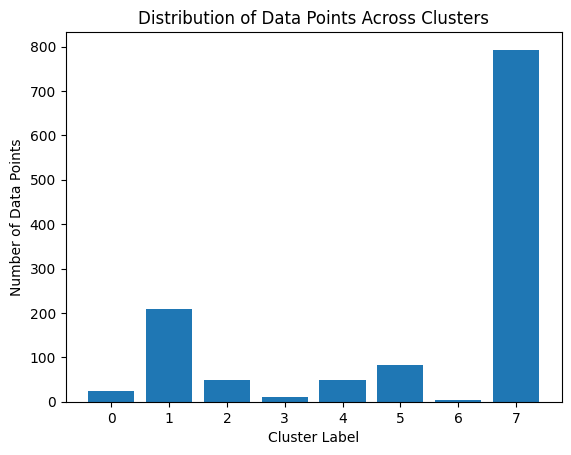

In [ ]:
cluster = df_test['Cluster'].value_counts()
plt.bar(cluster.index, cluster.values)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points Across Clusters')

In [ ]:
cluster

Cluster
7    793
1    208
5     83
4     49
2     48
0     25
3     11
6      4
Name: count, dtype: int64

From the output above it can be seen that the clusters are imbalanced with one cluster reaching 793 data points while the smallest is at 4 data points.

### Top 10 Topics

#### Printed

In [ ]:
centroids = KMeansModel.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(8):
  print(f"Cluster {i+1}: ")
  cluster_terms = []
  for j in centroids[i][:10]:
    cluster_terms.append(terms[j])
  print(", ".join(cluster_terms))
  print()

Cluster 1: 
tarik, tunai, atm, teller, bank, admin, gak, via, bsi, mandiri

Cluster 2: 
bank, bsi, syariah, indonesia, transfer, pakai, pindah, aceh, nasabah, data

Cluster 3: 
cek, saldo, coba, mutasi, transfer, bsi, transaksi, admin, gabisa, tf

Cluster 4: 
aplikasi, admin, mobile, error, buka, saldo, bsi, transaksi, gagal, erorr

Cluster 5: 
gak, bsi, bank, admin, pakai, uang, transaksi, atm, mbanking, transfer

Cluster 6: 
atm, mobile, bsi, banking, pulih, coba, urgent, transaksi, kc, error

Cluster 7: 
admin, dm, mobile, bsi, mbanking, transfer, cek, up, top, banking

Cluster 8: 
bsi, banget, transaksi, deh, uang, error, udh, kasih, sih, data



#### WordCloud

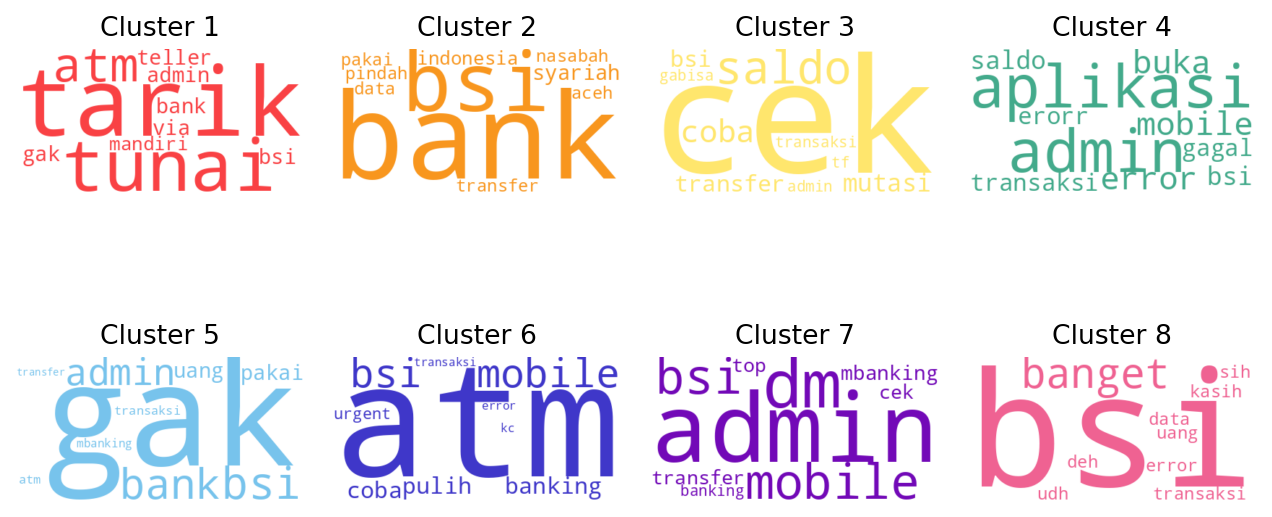

In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (10, 5),
                           sharex = True, sharey = True, dpi = 160)

for i, ax in enumerate(axes.flatten()):
    cluster_terms = [terms[j] for j in centroids[i][:10]]
    cluster_text = ' '.join(cluster_terms)
    wc.generate(cluster_text)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Cluster {i+1}")
    ax.axis("off")

plt.axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0)
plt.margins(x=0, y=0)
plt.show()

#### Analysis
**Cluster 1: Basic Banking Transaction**
- Withdrawing cash (tarik, tunai)
- Using ATMs (atm, teller)
- Interacting with bank staff (admin)
- Making transfers (via, transfer)
- Using BSI and Mandiri banks (bsi, mandiri)

**Cluster 2: BSI Banking Services in Indonesia**
- Opening BSI accounts (bank, bsi, syariah, indonesia)
- Transferring funds (transfer, pakai, pindah)
- Customer data and information (nasabah, data)
- Banking services in Aceh (aceh)

**Cluster 3: Checking Account Balance and Transaction**
- Checking account balance (cek, saldo)
- Viewing transaction history (mutasi, transfer)
- Troubleshooting BSI transactions (admin, gabisa, tf)

**Cluster 4: BSI Mobile Banking App Issues**
- Using the BSI mobile app (aplikasi, mobile)
- Encountering errors or app malfunctions (error, buka, gagal, erorr)
- Managing account balance and transactions through the app (saldo, transaksi)

**Cluster 5: General BSI Banking Activities**
- Using BSI banking services (bank, bsi, pakai)
- Managing money and transactions (uang, transaksi)
- Using ATMs and mobile banking (atm, mbanking, transfer)
- Interacting with BSI customer support (admin)

**Cluster 6: BSI Banking App Issues and Recovery**
- Using ATMs and mobile banking (atm, mobile, bsi)
- Encountering errors or app malfunctions (banking, pulih, coba, urgent, error)
- Seeking assistance for issues (kc; assumed to be Kantor Cabang)

**Cluster 7: BSI Mobile Banking and Transaction Management**
- Interacting with BSI customer support (admin, dm)
- Using the BSI mobile app (mobile, bsi, mbanking, transfer)
- Checking account balance and transactions (cek, up, top, banking)

**Cluster 8: BSI Banking Transactions and Data**
- Using BSI banking services (bsi, transaksi, deh, uang)
- Encountering errors or app malfunctions (error, udh)
- Providing data or information (kasih, sih, data)

## Topic Extraction (LDA and LSI)

### Build Dictionary and Corpus

#### Build Dictionary
The dictionary that is created is a filtered dictionary where words that appear less than 5 times in the entire collection of texts or in more than half of the documents are removed, focusing on the more informative terms within the texts.

In [ ]:
def build_dictionary(texts):
  dictionary = Dictionary(texts)
  dictionary.filter_extremes(no_below = 5, no_above = 0.5)

  return dictionary

In [ ]:
token_train = [text.split() for text in preprocessed_train]

In [ ]:
dictionary = build_dictionary(token_train)

In [ ]:
for key, value in dictionary.items():
  print(f"Key: {key}, Value: {value}")

Key: 0, Value: akses
Key: 1, Value: emang
Key: 2, Value: ewallet
Key: 3, Value: mbanking
Key: 4, Value: pakai
Key: 5, Value: saran
Key: 6, Value: tau
Key: 7, Value: topup
Key: 8, Value: wifi
Key: 9, Value: astaghfirullah
Key: 10, Value: bsi
Key: 11, Value: error
Key: 12, Value: jam
Key: 13, Value: wib
Key: 14, Value: bank
Key: 15, Value: hack
Key: 16, Value: otp
Key: 17, Value: sistem
Key: 18, Value: transaksi
Key: 19, Value: tuh
Key: 20, Value: admin
Key: 21, Value: aju
Key: 22, Value: apk
Key: 23, Value: mutasi
Key: 24, Value: potong
Key: 25, Value: rekening
Key: 26, Value: uang
Key: 27, Value: atmnya
Key: 28, Value: operasi
Key: 29, Value: pulih
Key: 30, Value: laptop
Key: 31, Value: ulang
Key: 32, Value: aman
Key: 33, Value: barusan
Key: 34, Value: biar
Key: 35, Value: cabang
Key: 36, Value: duit
Key: 37, Value: gabisa
Key: 38, Value: kantor
Key: 39, Value: kesana
Key: 40, Value: laki
Key: 41, Value: lapor
Key: 42, Value: manual
Key: 43, Value: pas
Key: 44, Value: saudara
Key: 45, 

#### Build Corpus (BoW Only and Additional TF-IDF)

##### Bag of Words (BoW Corpus)
This method converts a text document into a BOW numerical representation. It creates a list of tuples where the first element is the index from the dictionary and the second element is the word's frequency within that specific document.

In [ ]:
def build_corpus(dictionary, texts):
  corpus = [dictionary.doc2bow(text) for text in texts]

  return corpus

In [ ]:
corpus_bow = build_corpus(dictionary, token_train)

In [ ]:
for doc in corpus_bow:
  print(doc)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]
[(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
[(1, 2), (10, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]
[(10, 1), (18, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 3), (26, 2)]
[(27, 1), (28, 1), (29, 1)]
[(30, 1), (31, 1)]
[(3, 1), (12, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]
[(12, 2), (47, 1), (48, 1)]
[(14, 1), (49, 1), (50, 1), (51, 1), (52, 1)]
[(53, 1), (54, 1)]
[(55, 1), (56, 1), (57, 1)]
[(11, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)]
[(63, 1), (64, 1)]
[(4, 1), (19, 1), (59, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1)]
[(66, 1), (68, 1), (72, 1)]
[(10, 1), (73, 1), (74, 1)]
[(10, 2), (14, 1), (20, 1), (23, 1), (55, 1), (57, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)]
[(55, 1), (57, 1), (58, 1), (81, 1), (82, 1)]
[(83, 1), (84, 1), (85, 1)]
[(72

In [ ]:
for doc_id, doc in enumerate(corpus_bow):
    print(f"\nDocument {doc_id + 1}:")
    for word_id, count in doc:
      word = dictionary.get(word_id, "<UNKNOWN>")
      print(f"  - Word: {word} (ID: {word_id}) - Count: {count}")

Streaming output truncated to the last 5000 lines.
  - Word: abang (ID: 960) - Count: 1
  - Word: lalai (ID: 979) - Count: 1
  - Word: koran (ID: 1063) - Count: 1

Document 4243:
  - Word: saran (ID: 5) - Count: 1
  - Word: admin (ID: 20) - Count: 1
  - Word: pulih (ID: 29) - Count: 1
  - Word: nasabah (ID: 118) - Count: 2
  - Word: resmi (ID: 141) - Count: 1
  - Word: data (ID: 152) - Count: 1
  - Word: layan (ID: 163) - Count: 1
  - Word: bocor (ID: 172) - Count: 1
  - Word: panik (ID: 517) - Count: 1
  - Word: ikan (ID: 700) - Count: 1
  - Word: menang (ID: 713) - Count: 1
  - Word: media (ID: 794) - Count: 1

Document 4244:
  - Word: top (ID: 69) - Count: 1
  - Word: up (ID: 71) - Count: 1
  - Word: gitu (ID: 72) - Count: 1
  - Word: sih (ID: 100) - Count: 1
  - Word: bohong (ID: 149) - Count: 1
  - Word: yaa (ID: 297) - Count: 1
  - Word: wkwk (ID: 557) - Count: 1

Document 4245:
  - Word: bsi (ID: 10) - Count: 1
  - Word: bank (ID: 14) - Count: 4
  - Word: biar (ID: 34) - Count: 

##### Additional TF-IDF Corpus from the BoW Corpus
This method converts the BOW corpus and transforms it into a TF-IDF weighted corpus which helps identify which words are most important and informative for each document compared to the entire collection. Similar to the BOW method, the first element is the index but the second element is the TF-IDF weight.

In [ ]:
def build_tfidf(corpus):
  tfidf = models.TfidfModel(corpus)
  corpus_tfidf = tfidf[corpus]

  return corpus_tfidf

In [ ]:
corpus_tfidf = build_tfidf(corpus_bow)

In [ ]:
for doc in corpus_tfidf:
  print(doc)

[(0, 0.2797540070675295), (1, 0.2845876141870396), (2, 0.40076226910567464), (3, 0.24682578072247266), (4, 0.19998809655449), (5, 0.3223494476516065), (6, 0.37533728620236106), (7, 0.3522007137650401), (8, 0.45867896905990974)]
[(9, 0.6268127549666105), (10, 0.11256107793151676), (11, 0.2941501025909), (12, 0.4091371709659818), (13, 0.5835394300523136)]
[(1, 0.6223927703601164), (10, 0.090069508872641), (14, 0.11413631850595396), (15, 0.4138365482253228), (16, 0.425067845902253), (17, 0.2704377129863092), (18, 0.21760401804751608), (19, 0.3450452089655606)]
[(10, 0.07144734972134144), (18, 0.1726136910571355), (20, 0.13968108133816184), (21, 0.40723281161822616), (22, 0.3651097949622529), (23, 0.28345013781587985), (24, 0.26338113015533016), (25, 0.6109707151652335), (26, 0.3513494628123245)]
[(27, 0.6264757972278236), (28, 0.6650301745288296), (29, 0.40652545117608224)]
[(30, 0.7607627167127609), (31, 0.649030113985337)]
[(3, 0.16218229542922458), (12, 0.19672196949642798), (32, 0.147

In [ ]:
for doc_id, doc in enumerate(corpus_tfidf):
    print(f"\nDocument {doc_id + 1}:")
    for word_id, weight in doc:
      word = dictionary.get(word_id, "<UNKNOWN>")
      print(f"  - Word: {word} (ID: {word_id}) - Weight: {weight}")

Streaming output truncated to the last 5000 lines.
  - Word: abang (ID: 960) - Weight: 0.3450112110491493
  - Word: lalai (ID: 979) - Weight: 0.3450112110491493
  - Word: koran (ID: 1063) - Weight: 0.36723122518751966

Document 4243:
  - Word: saran (ID: 5) - Weight: 0.2637559527361136
  - Word: admin (ID: 20) - Weight: 0.13176074759680872
  - Word: pulih (ID: 29) - Weight: 0.2105321062690677
  - Word: nasabah (ID: 118) - Weight: 0.34393028315980867
  - Word: resmi (ID: 141) - Weight: 0.2958358098291174
  - Word: data (ID: 152) - Weight: 0.18728890440677456
  - Word: layan (ID: 163) - Weight: 0.20782334460451546
  - Word: bocor (ID: 172) - Weight: 0.26034951768231784
  - Word: panik (ID: 517) - Weight: 0.32116377922828626
  - Word: ikan (ID: 700) - Weight: 0.3841414971213306
  - Word: menang (ID: 713) - Weight: 0.3444069810905794
  - Word: media (ID: 794) - Weight: 0.3841414971213306

Document 4244:
  - Word: top (ID: 69) - Weight: 0.3461110372938636
  - Word: up (ID: 71) - Weight: 0.3

### Output Preparation
Below are some functions to help output the topic modelling result, coherence score and topics.

In [ ]:
def coherence_score(model, texts, dictionary):
    coherence_model = CoherenceModel(model = model,
                                         texts = texts,
                                         dictionary = dictionary,
                                         coherence='c_v')
    coherence_lda = coherence_model.get_coherence()

    return coherence_lda

In [ ]:
def model_topics(model):
  topics = model.show_topics(num_words = 10, formatted = True)

  for topic_num, topic in topics:
    print(f"Topic {topic_num}:")

    words = [word.split('*')[1].strip().replace('"', '') for word in topic.split('+')]
    weights = [word.split('*')[0].strip().replace('"', '') for word in topic.split('+')]
    topic_words_weights = [f"{words[i]}: {weights[i]}" for i in range(len(words))]
    print("\n".join(topic_words_weights))

    print()

### Test Data Preparation
Applying the same process that has been done to the training set.

In [ ]:
preprocessed_test = [preprocess(text) for text in x_test]

In [ ]:
token_test = [text.split() for text in preprocessed_test]

In [ ]:
corpus_test_bow = build_corpus(dictionary, token_test)

In [ ]:
corpus_test_tfidf = build_tfidf(corpus_test_bow)

### Model Building and Testing

#### Model Functions


##### LDA Model
The base model will use 8 topics, 15 passes, 2 workers, 0.5 alpha and 0.7 eta as the hyperparameters.

In [ ]:
def model_lda(dictionary, corpus, num_topic, alpha, eta):
  lda_model =  gensim.models.LdaMulticore(corpus,
                                  num_topics = num_topic,
                                  id2word = dictionary,
                                  passes = 15,
                                  workers = 2,
                                  alpha = alpha,
                                  eta = eta)
  return lda_model

##### LSI Model
Unlike the LDA model, LSA does not have as many hyperparameters, thus the base model will use 8 topics and false setting for onepass.

In [ ]:
def model_lsi(dictionary, corpus, num_topic):
  lsi_model = LsiModel(corpus,
                        num_topics = num_topic,
                        id2word = dictionary,
                        onepass = False)
  return lsi_model

#### LDA + BoW Corpus

In [ ]:
lda_model = model_lda(dictionary, corpus_bow, 8, 0.5, 0.7)

##### Coherence Score

In [ ]:
lda_coherence = coherence_score(lda_model, token_train, dictionary)
lda_coherence

0.34016092338957354

##### Top 10 Topics

In [ ]:
model_topics(lda_model)

Topic 0:
bsi: 0.115
mobile: 0.072
banking: 0.046
bank: 0.026
eror: 0.014
atm: 0.014
ganggu: 0.013
cash: 0.012
layan: 0.012
indonesia: 0.010

Topic 1:
data: 0.059
bsi: 0.048
bank: 0.039
nasabah: 0.038
lockbit: 0.022
ransomware: 0.020
bohong: 0.017
bocor: 0.014
hacker: 0.013
serang: 0.013

Topic 2:
bsi: 0.092
pulih: 0.036
akun: 0.035
coba: 0.027
tipu: 0.022
hati: 0.018
bca: 0.017
atm: 0.016
kayak: 0.012
bilang: 0.012

Topic 3:
bank: 0.167
bsi: 0.078
syariah: 0.041
aceh: 0.020
pindah: 0.018
gak: 0.015
emang: 0.014
uang: 0.012
maintenance: 0.011
pakai: 0.011

Topic 4:
pakai: 0.043
banget: 0.041
rekening: 0.030
duit: 0.027
buka: 0.024
tf: 0.024
uang: 0.020
coba: 0.018
pas: 0.015
ambil: 0.015

Topic 5:
aman: 0.046
sistem: 0.044
bayar: 0.042
gak: 0.041
gin: 0.027
pakai: 0.015
lancar: 0.013
bi: 0.013
uang: 0.012
transaksi: 0.012

Topic 6:
saldo: 0.083
cek: 0.049
admin: 0.036
transaksi: 0.028
kasih: 0.026
bsi: 0.020
terima: 0.019
mas: 0.016
informasi: 0.015
gagal: 0.015

Topic 7:
atm: 0.060
adm

###### Printed

In [ ]:
topics_test = lda_model.get_document_topics(corpus_test_bow)

top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    top_words = lda_model.show_topic(topic_id, topn=10)
    top_words_per_topic.append([word for word, _ in top_words])

for i, topic_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(topic_words)}")


Topic 1: bsi, mobile, banking, bank, eror, atm, ganggu, cash, layan, indonesia
Topic 2: data, bsi, bank, nasabah, lockbit, ransomware, bohong, bocor, hacker, serang
Topic 3: bsi, pulih, akun, coba, tipu, hati, bca, atm, kayak, bilang
Topic 4: bank, bsi, syariah, aceh, pindah, gak, emang, uang, maintenance, pakai
Topic 5: pakai, banget, rekening, duit, buka, tf, uang, coba, pas, ambil
Topic 6: aman, sistem, bayar, gak, gin, pakai, lancar, bi, uang, transaksi
Topic 7: saldo, cek, admin, transaksi, kasih, bsi, terima, mas, informasi, gagal
Topic 8: atm, admin, transfer, tarik, sih, gabisa, error, udh, up, mbanking


###### WordCloud

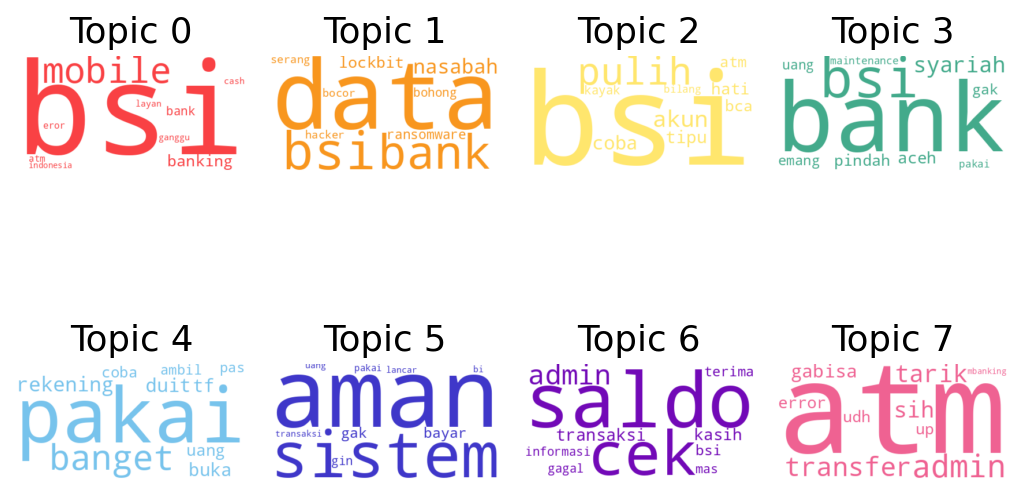

In [ ]:
topics_lda_base = lda_model.show_topics(formatted = False)

fig, axes = plt.subplots(2, 4, figsize = (8, 5),
                           sharex = True, sharey = True, dpi = 160)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(topics_lda_base[i][1])
    wc.generate_from_frequencies(topic_words)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title("Topic " + str(i), fontdict = dict(size = 16))
    ax.axis("off")

plt.axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0)
plt.margins(x=0, y=0)
plt.show()

###### Analysis
**Cluster 1: BSI Mobile Banking Issues and General Banking**

- BSI mobile banking (bsi, mobile, banking)
- Encountering errors or app malfunctions (eror, atm, ganggu)
- Cash transactions and services (cash, layan)
- BSI services in Indonesia (indonesia)

**Cluster 2: BSI Data Security Concerns and Cyberattacks**
- Data security and privacy (data, bsi, bank, nasabah)
- Lockbit ransomware attack (lockbit, ransomware)
- Data breaches and leaks (bohong, bocor)
- Cybersecurity threats and hacker attacks (hacker, serang)

**Cluster 3: BSI Account Recovery and Fraudulent Activities**
- BSI account issues and recovery (bsi, pulih, akun)
- Troubleshooting account problems (coba)
- Scams and fraudulent activities (tipu, hati)
- Comparing BSI with BCA (bca, atm)
- User experiences and opinions (kayak, bilang)

**Cluster 4: BSI Banking Services and Customer Preferences**
- BSI banking services (bank, bsi, syariah)
- Banking services in Aceh (aceh, pindah)
- Customer preferences and considerations (gak, emang, uang)
- Bank maintenance and service disruptions (maintenance, pakai)

**Cluster 5: BSI Mobile Banking Transactions and Money Management**
- Using BSI mobile banking (pakai, banget, rekening)
- Managing money and transactions (duit, buka, tf, uang)
- Troubleshooting transactions and issues (coba, pas, ambil)

**Cluster 6: BSI Banking System Security and Transactions**
- Security and reliability of BSI systems (aman, sistem, bayar)
- Customer experiences with BSI transactions (gak, gin, pakai)
- Smoothness and efficiency of transactions (lancar, bi)
- Money management and transaction-related concerns (uang, transaksi)

**Cluster 7: BSI Account Balance, Transactions, and Support**
- Checking account balance (saldo, cek)
- Managing transactions and account activity (admin, transaksi)
- Interacting with BSI customer support (kasih, bsi, terima)
- Customer service interactions and experiences (mas, informasi)
- Troubleshooting transaction errors (gagal)

**Cluster 8: BSI ATM Transactions and Mobile Banking Issues**
- Using BSI ATMs (atm, admin, transfer)
- Withdrawing cash and managing transactions (tarik, sih)
- Encountering errors or app malfunctions (gabisa, error)
- Troubleshooting ATM and mobile banking issues (udh, up, mbanking)

##### Topic Visualization

In [ ]:
visual_lda_base = pyLDAvis.gensim.prepare(topic_model = lda_model,
                                          corpus = corpus_test_bow,
                                          dictionary = dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(visual_lda_base)

There are some topic cluster that overlap each other, such as 3 and 5, 1 and 6. There are also some cluster that have a small distance between each other. This means that most of the cluster will have similar topics.

#### LDA + BoW and TF-IDF Corpus

In [ ]:
lda_tfidf_model = model_lda(dictionary, corpus_tfidf, 8, 0.5, 0.7)

##### Coherence Score

In [ ]:
lda_tfidf_coherence = coherence_score(lda_tfidf_model, token_train, dictionary)
lda_tfidf_coherence

0.33069419100903796

##### Top 10 Topics

In [ ]:
model_topics(lda_tfidf_model)

Topic 0:
cek: 0.044
saldo: 0.033
udh: 0.022
tipu: 0.021
admin: 0.017
dm: 0.014
hati: 0.014
mbankingnya: 0.010
down: 0.010
balas: 0.008

Topic 1:
transfer: 0.033
up: 0.022
top: 0.021
tf: 0.019
pakai: 0.017
rekening: 0.016
uang: 0.016
bang: 0.015
gak: 0.014
gabisa: 0.014

Topic 2:
mobile: 0.020
buka: 0.020
deh: 0.019
eror: 0.017
transaksi: 0.012
gin: 0.012
bsi: 0.012
banking: 0.011
mei: 0.010
duit: 0.010

Topic 3:
bank: 0.025
bsi: 0.024
syariah: 0.017
nasabah: 0.016
aceh: 0.015
error: 0.012
ganti: 0.012
parah: 0.010
maaf: 0.009
jam: 0.009

Topic 4:
kasih: 0.021
sistem: 0.020
bayar: 0.018
terima: 0.018
aman: 0.016
indonesia: 0.011
bank: 0.010
info: 0.009
layan: 0.008
lancar: 0.008

Topic 5:
data: 0.019
bsi: 0.014
mas: 0.014
bank: 0.013
hilang: 0.010
ransomware: 0.010
rek: 0.008
tolong: 0.008
bocor: 0.008
lockbit: 0.007

Topic 6:
tarik: 0.029
atm: 0.022
tunai: 0.020
alhamdulillah: 0.015
tutup: 0.011
gak: 0.011
bank: 0.010
bsi: 0.010
mandiri: 0.009
lebih: 0.009

Topic 7:
admin: 0.033
coba: 

###### Printed

In [ ]:
topics_test_tfidf = lda_tfidf_model.get_document_topics(corpus_test_tfidf)

top_words_per_topic = []
for topic_id in range(lda_tfidf_model.num_topics):
    top_words = lda_tfidf_model.show_topic(topic_id, topn=10)
    top_words_per_topic.append([word for word, _ in top_words])

for i, topic_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(topic_words)}")


Topic 1: cek, saldo, udh, tipu, admin, dm, hati, mbankingnya, down, balas
Topic 2: transfer, up, top, tf, pakai, rekening, uang, bang, gak, gabisa
Topic 3: mobile, buka, deh, eror, transaksi, gin, bsi, banking, mei, duit
Topic 4: bank, bsi, syariah, nasabah, aceh, error, ganti, parah, maaf, jam
Topic 5: kasih, sistem, bayar, terima, aman, indonesia, bank, info, layan, lancar
Topic 6: data, bsi, mas, bank, hilang, ransomware, rek, tolong, bocor, lockbit
Topic 7: tarik, atm, tunai, alhamdulillah, tutup, gak, bank, bsi, mandiri, lebih
Topic 8: admin, coba, mbanking, atm, pulih, transaksi, normal, mobile, urgent, akses


###### WordCloud

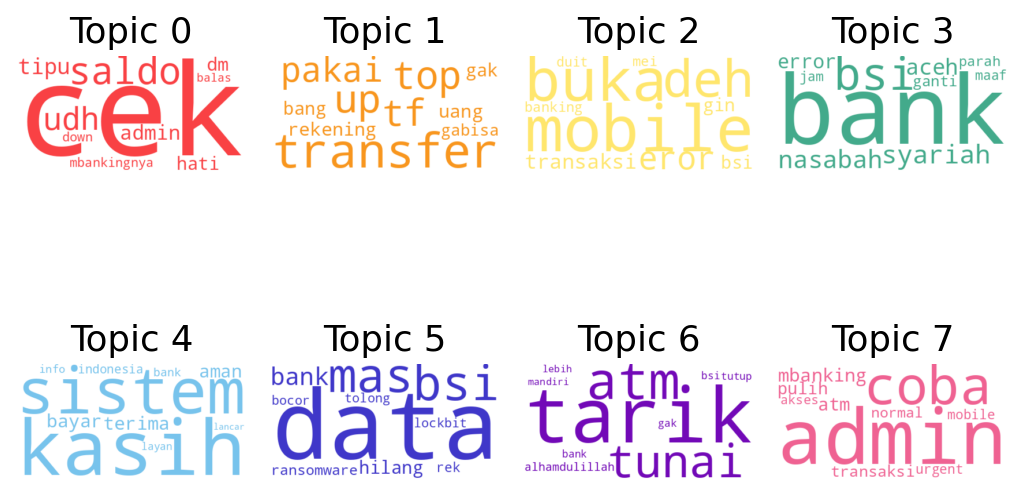

In [ ]:
topics_lda_tfidf = lda_tfidf_model.show_topics(formatted = False)

fig, axes = plt.subplots(2, 4, figsize = (8, 5),
                           sharex = True, sharey = True, dpi = 160)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(topics_lda_tfidf[i][1])
    wc.generate_from_frequencies(topic_words)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title("Topic " + str(i), fontdict = dict(size = 16))
    ax.axis("off")

plt.axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0)
plt.margins(x=0, y=0)
plt.show()

###### Analysis
**Cluster 1: BSI Mobile Banking Issues and Account Management**
- Checking account balance (cek, saldo)
- Resolving fraudulent activities and scams (udh, tipu)
- Interacting with BSI customer support (admin, dm)
- Caution and awareness regarding mobile banking security (hati, mbankingnya)
- Experiencing mobile banking downtime (down, balas)

**Cluster 2: BSI Transactions, Money Management, and Common Issues**
- Making transfers and adding funds (transfer, up, top, tf)
- Using BSI banking services (pakai, rekening, uang)
- Addressing transaction failures and limitations (bang, gak, gabisa)

**Cluster 3: BSI Mobile Banking, Transactions, and Banking Services**
- Using the BSI mobile app (mobile, buka, deh)
- Encountering errors or app malfunctions (eror, transaksi)
- Managing transactions and account activity (gin, bsi, banking)
- Seasonal events and banking updates (mei, duit)

**Cluster 4: BSI Banking Services, Customer Support, and Errors**
- BSI banking services (bank, bsi, syariah, nasabah)
- Banking services in Aceh (aceh, error)
- Requesting account changes or replacements (ganti, parah)
- Apologizing for inconveniences and seeking assistance (maaf, jam)

**Cluster 5: BSI Security, Transactions, and Customer Service**
- Security and reliability of BSI systems (kasih, sistem)
- Making payments and receiving transactions (bayar, terima)
- Experiencing smooth and secure transactions (aman, indonesia)
- Accessing banking information and support (bank, info, layan)
- Enjoying efficient and reliable banking services (lancar)

**Cluster 6: BSI Data Security Concerns, Cyberattacks, and Assistance**
- Data security and privacy issues (data, bsi, mas, bank)
- Experiencing data loss or theft (hilang, ransomware)
- Requesting help with compromised accounts (rek, tolong)
- Concerns about data breaches and leaks (bocor, lockbit)

**Cluster 7: BSI ATM Transactions, Cash Management, and Banking Comparisons**
- Withdrawing cash from ATMs (tarik, atm, tunai)
- Expressing gratitude for successful transactions (alhamdulillah)
- Closing accounts or experiencing service disruptions (tutup, gak)
- Comparing BSI with other banks (bank, bsi, mandiri)
- Preferring BSI over other banking options (lebih)

**Cluster 8: BSI Mobile Banking, Transactions, and Urgent Assistance**
- Interacting with BSI customer support (admin, coba)
- Using the BSI mobile app for transactions (mbanking, atm)
- Requesting service restoration and resolving issues (pulih, transaksi)
- Experiencing normal service operation (normal, mobile)
- Seeking urgent assistance for critical banking needs (urgent, akses)

##### Topic Visualization

In [ ]:
visual_lda_tfidf = pyLDAvis.gensim.prepare(topic_model = lda_tfidf_model,
                                          corpus = corpus_test_tfidf,
                                          dictionary = dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(visual_lda_tfidf)

Most topic clusters overlap with each other, except for 1 and 3. This means that most of the cluster will have similar or even identical topics.

#### LSI + BoW Corpus

In [ ]:
lsi_model = model_lsi(dictionary, corpus_bow, 8)

##### Coherence Score

In [ ]:
lsi_model_coherence = coherence_score(lsi_model, token_train, dictionary)
lsi_model_coherence

0.43092777972530477

##### Top 10 Topics

In [ ]:
model_topics(lsi_model)

Topic 0:
bsi: -0.649
bank: -0.622
syariah: -0.183
aceh: -0.136
atm: -0.097
nasabah: -0.085
gak: -0.077
data: -0.076
uang: -0.074
layan: -0.070

Topic 1:
bank: -0.597
bsi: 0.550
syariah: -0.250
admin: 0.203
aceh: -0.181
mobile: 0.174
saldo: 0.169
atm: 0.139
cek: 0.137
gak: 0.112

Topic 2:
bsi: -0.469
admin: 0.404
saldo: 0.350
gak: 0.285
atm: 0.261
cek: 0.239
bank: 0.176
transfer: 0.174
transaksi: 0.141
uang: 0.134

Topic 3:
atm: 0.688
data: -0.294
saldo: -0.258
nasabah: -0.192
admin: -0.186
aman: -0.172
aceh: 0.167
tarik: 0.162
tunai: 0.137
cek: -0.130

Topic 4:
data: 0.364
atm: 0.328
sistem: 0.313
nasabah: 0.308
saldo: -0.264
gak: 0.257
bayar: 0.237
aman: 0.227
indonesia: 0.191
admin: -0.188

Topic 5:
gak: 0.732
admin: -0.278
pakai: 0.248
syariah: -0.245
atm: -0.175
indonesia: -0.154
saldo: -0.142
cek: -0.127
data: -0.127
sistem: -0.114

Topic 6:
admin: 0.559
syariah: 0.448
gak: 0.313
saldo: -0.309
cek: -0.185
bank: -0.184
aceh: 0.161
coba: -0.139
atm: -0.135
tarik: -0.116

Topic 7:
ad

###### Printed

In [ ]:
top_words_per_topic = []
for topic_id in range(lsi_model.num_topics):
    top_words = lsi_model.show_topic(topic_id, topn=10)
    top_words_per_topic.append([word for word, _ in top_words])

for i, topic_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(topic_words)}")

Topic 1: bsi, bank, syariah, aceh, atm, nasabah, gak, data, uang, layan
Topic 2: bank, bsi, syariah, admin, aceh, mobile, saldo, atm, cek, gak
Topic 3: bsi, admin, saldo, gak, atm, cek, bank, transfer, transaksi, uang
Topic 4: atm, data, saldo, nasabah, admin, aman, aceh, tarik, tunai, cek
Topic 5: data, atm, sistem, nasabah, saldo, gak, bayar, aman, indonesia, admin
Topic 6: gak, admin, pakai, syariah, atm, indonesia, saldo, cek, data, sistem
Topic 7: admin, syariah, gak, saldo, cek, bank, aceh, coba, atm, tarik
Topic 8: admin, syariah, saldo, cek, gak, bank, indonesia, uang, aceh, transaksi


###### WordCloud

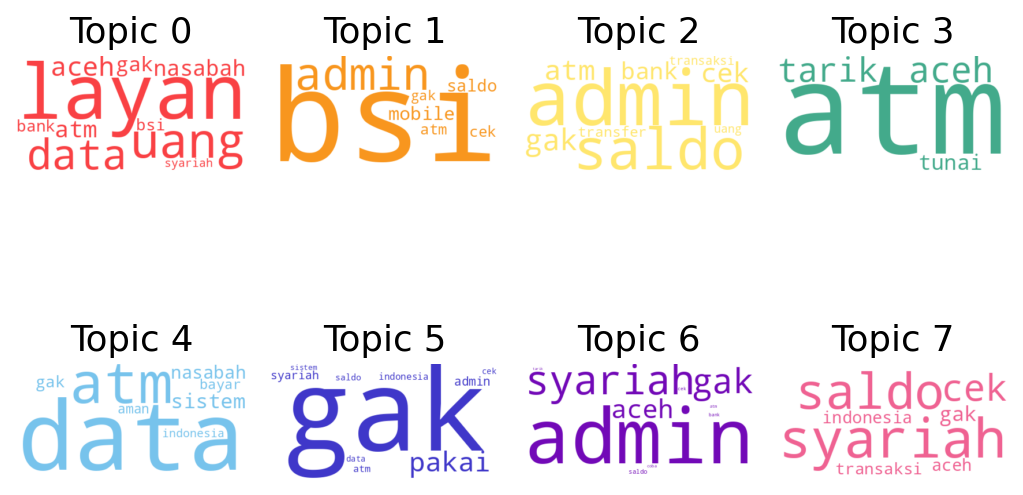

In [ ]:
topic_lsi = lsi_model.show_topics(formatted = False)

fig, axes = plt.subplots(2, 4, figsize = (8, 5),
                           sharex = True, sharey = True, dpi = 160)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(topic_lsi[i][1])
    wc.generate_from_frequencies(topic_words)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title("Topic " + str(i), fontdict = dict(size = 16))
    ax.axis("off")

plt.axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0)
plt.margins(x=0, y=0)
plt.show()

###### Analysis
**Cluster 1: Basic Banking Services and Customer Interactions**
- BSI banking services (bsi, bank, syariah)
- Banking services in Aceh (aceh, atm)
- Customer data and information (nasabah, gak)
- Managing money and transactions (data, uang)
- Customer service and support (layan)

**Cluster 2: BSI Banking Services, Mobile App, and Account Management**
- BSI banking services (bank, bsi, syariah)
- Using the BSI mobile app (admin, mobile)
- Checking account balance (saldo, atm)
- Troubleshooting account issues (cek, gak)

**Cluster 3: BSI Banking Services, Account Balance, and Transactions**
- BSI banking services (bsi, admin, saldo)
- Checking account balance (saldo, atm)
- Making transfers and managing transactions (cek, bank, transfer, transaksi, uang)

**Cluster 4: BSI ATM Transactions, Data Security, and Customer Safety**
- Using BSI ATMs (atm, data, saldo)
- Protecting customer data and privacy (nasabah, admin, aman)
- Withdrawing cash and managing transactions (aceh, tarik, tunai, cek)

**Cluster 5: BSI Data Security, Payment Systems, and Customer Service**
- Data security and privacy concerns (data, atm, sistem)
- Making payments and handling transactions (nasabah, saldo, gak, bayar, aman)
- Accessing banking information and support (indonesia, admin)

**Cluster 6: BSI Banking Services, Customer Interactions, and Data Security**
- Using BSI banking services (gak, admin, pakai)
- Interacting with BSI customer support (syariah, atm, indonesia)
- Balancing convenience and data protection (saldo, cek, data, sistem)

**Cluster 7: BSI Customer Support, Account Management, and ATM Transactions**
- Interacting with BSI customer support (admin, syariah)
- Managing account balance and transactions (gak, saldo, cek)
- Using BSI ATMs and troubleshooting issues (bank, aceh, coba, atm, tarik)

**Cluster 8: BSI Banking Services, Customer Support, and Transactions**
- BSI banking services (admin, syariah, saldo)
- Interacting with BSI customer support (cek, gak)
- Making transfers, checking balances, and managing transactions (bank, indonesia, uang, aceh, transaksi)


##### Topic Visualization

In [ ]:
lsi_corpus = lsi_model[corpus_test_bow]

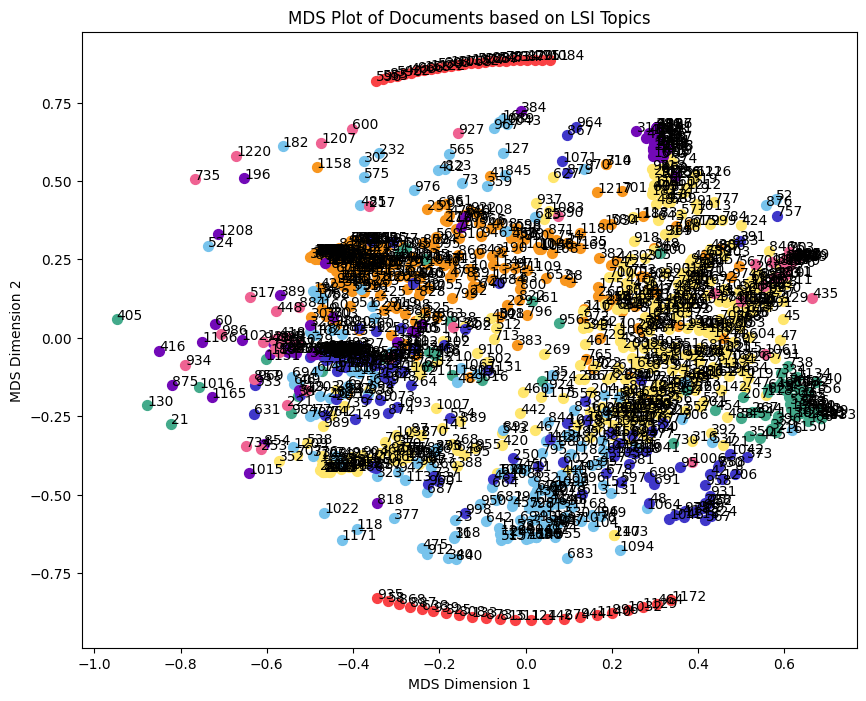

In [ ]:
# Extract document-topic distributions from LSI model
doc_topic_dist = np.zeros((len(corpus_test_bow), lsi_model.num_topics))

for i, doc in enumerate(lsi_corpus):
    for topic_id, topic_prob in doc:
        doc_topic_dist[i, topic_id] = topic_prob

# Compute cosine similarity matrix between documents
doc_similarity = cosine_similarity(doc_topic_dist)

# Apply MDS to reduce dimensionality
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
doc_coords = mds.fit_transform(1 - doc_similarity)  # Use 1 - similarity for distance

topics = np.argmax(doc_topic_dist, axis=1)

# Plotting
plt.figure(figsize=(10, 8))
for topic_id in range(lsi_model.num_topics):
  mask = topics == topic_id
  plt.scatter(doc_coords[mask, 0], doc_coords[mask, 1],
              color = list_colors[topic_id], s = 50,
              marker='o', label=f'Topic {topic_id}')

plt.title('MDS Plot of Documents based on LSI Topics')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')

# Optionally label points with document indices or other metadata
for i, txt in enumerate(range(len(doc_coords))):
    plt.annotate(txt, (doc_coords[i, 0], doc_coords[i, 1]))

plt.show()

#### LSI + BoW and TF-IDF Corpus

In [ ]:
lsi_tfidf_model = model_lsi(dictionary, corpus_tfidf, 8)

##### Coherence Score

In [ ]:
lsi_tfidf_model_coherence = coherence_score(lsi_tfidf_model, token_train, dictionary)
lsi_tfidf_model_coherence

0.3670727336973831

##### Top 10 Topics

In [ ]:
model_topics(lsi_tfidf_model)

Topic 0:
admin: 0.405
bsi: 0.377
bank: 0.302
cek: 0.229
atm: 0.219
saldo: 0.214
mobile: 0.210
gak: 0.188
transfer: 0.170
transaksi: 0.139

Topic 1:
admin: 0.683
bank: -0.396
bsi: -0.341
cek: 0.264
saldo: 0.176
syariah: -0.160
dm: 0.139
atm: -0.101
indonesia: -0.087
pindah: -0.079

Topic 2:
admin: -0.531
cek: 0.522
saldo: 0.431
atm: 0.234
bank: -0.223
coba: 0.197
bsi: -0.137
transaksi: 0.108
syariah: -0.089
gak: 0.075

Topic 3:
atm: -0.666
saldo: 0.315
cek: 0.310
bank: 0.289
mobile: -0.205
tarik: -0.185
tunai: -0.165
banking: -0.139
syariah: 0.119
transfer: 0.105

Topic 4:
mobile: -0.627
banking: -0.403
atm: 0.280
gak: 0.253
tarik: 0.224
bsi: -0.182
tunai: 0.166
bank: 0.152
transaksi: -0.147
uang: 0.142

Topic 5:
gak: -0.828
atm: 0.197
top: -0.187
up: -0.185
bank: 0.172
cek: 0.148
transaksi: -0.122
admin: 0.118
bsi: 0.106
pakai: -0.095

Topic 6:
top: 0.523
up: 0.519
transfer: 0.360
gak: -0.312
gabisa: 0.229
wallet: 0.141
admin: -0.122
tf: 0.100
cek: -0.092
pakai: 0.091

Topic 7:
transfe

###### Printed

In [ ]:
top_words_per_topic = []
for topic_id in range(lsi_tfidf_model.num_topics):
    top_words = lsi_tfidf_model.show_topic(topic_id, topn=10)
    top_words_per_topic.append([word for word, _ in top_words])

for i, topic_words in enumerate(top_words_per_topic):
    print(f"Topic {i + 1}: {', '.join(topic_words)}")

Topic 1: admin, bsi, bank, cek, atm, saldo, mobile, gak, transfer, transaksi
Topic 2: admin, bank, bsi, cek, saldo, syariah, dm, atm, indonesia, pindah
Topic 3: admin, cek, saldo, atm, bank, coba, bsi, transaksi, syariah, gak
Topic 4: atm, saldo, cek, bank, mobile, tarik, tunai, banking, syariah, transfer
Topic 5: mobile, banking, atm, gak, tarik, bsi, tunai, bank, transaksi, uang
Topic 6: gak, atm, top, up, bank, cek, transaksi, admin, bsi, pakai
Topic 7: top, up, transfer, gak, gabisa, wallet, admin, tf, cek, pakai
Topic 8: transfer, top, up, pakai, transaksi, bsi, mbanking, cek, atm, syariah


###### WordCloud

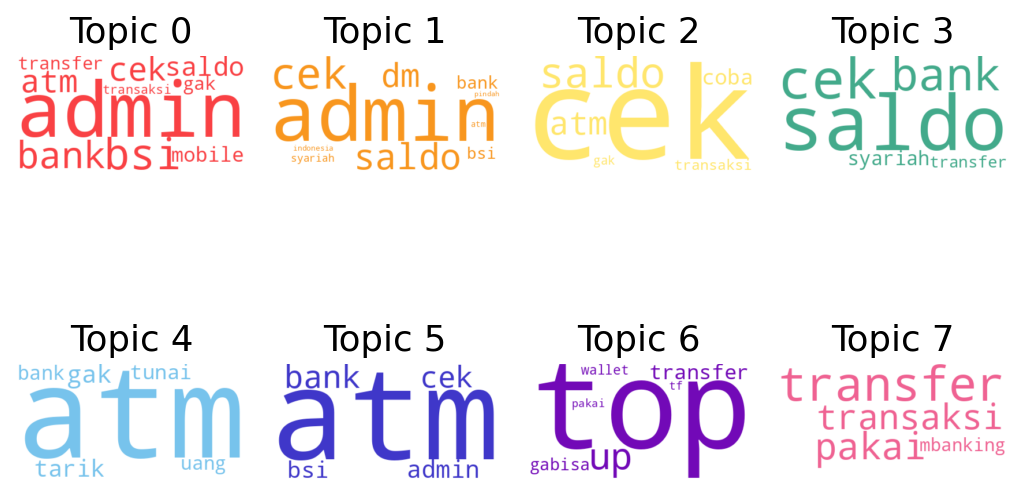

In [ ]:
topic_lsi_tfidf = lsi_tfidf_model.show_topics(formatted = False)

fig, axes = plt.subplots(2, 4, figsize = (8, 5),
                           sharex = True, sharey = True, dpi = 160)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(topic_lsi_tfidf[i][1])
    wc.generate_from_frequencies(topic_words)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title("Topic " + str(i), fontdict = dict(size = 16))
    ax.axis("off")

plt.axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0)
plt.margins(x=0, y=0)
plt.show()

###### Analysis
**Cluster 1: Basic Banking Transactions and Account Management**
- Interacting with BSI customer support (admin, bsi, bank)
- Checking account balance (cek, atm, saldo)
- Using the BSI mobile app (mobile)
- Troubleshooting account issues (gak, transfer, transaksi)

**Cluster 2: BSI Banking Services, Account Management, and Regional Considerations**
- Interacting with BSI customer support (admin, bank, bsi)
- Checking account balance (cek, saldo)
- BSI services in Indonesia (syariah, dm, atm, indonesia)
- Moving accounts or changing information (pindah)

**Cluster 3: BSI Banking Services, Account Management, and Transaction Issues**
- Interacting with BSI customer support (admin, cek, saldo)
- Checking account balance (atm, bank)
- Managing transactions and resolving issues (coba, bsi, transaksi, syariah, gak)

**Cluster 4: BSI Banking Transactions, Mobile App, and Syariah Banking**
- Using BSI ATMs and checking balances (atm, saldo, cek)
- Using the BSI mobile app (bank, mobile)
- Withdrawing cash and managing transactions (tarik, tunai, banking)
- BSI Syariah banking services (syariah, transfer)

**Cluster 5: BSI Mobile App, Transactions, and Money Management**
- Using the BSI mobile app (mobile, banking)
- Using BSI ATMs and managing transactions (atm, gak, tarik)
- Managing money and transactions (bsi, tunai, bank, transaksi, uang)

**Cluster 6: BSI Banking Services, Transactions, and Customer Support**
- Troubleshooting account issues (gak, atm, top, up)
- Managing transactions and resolving issues (bank, cek, transaksi, admin)
- Using BSI banking services (bsi, pakai)

**Cluster 7: BSI Mobile App, Transactions, and Wallet Issues**
- Making transfers and adding funds (top, up, transfer)
- Troubleshooting transaction and wallet issues (gak, gabisa, wallet)
- Interacting with BSI customer support (admin, tf, cek, pakai)

Cluster 8: BSI Transactions, Mobile App, and Syariah Banking
- Making transfers and adding funds (transfer, top, up)
- Using the BSI mobile app (pakai, transaksi)
- Using BSI ATMs and checking balances (bsi, mbanking, cek, atm)
- BSI Syariah banking services (syariah)

##### Topic Visualization

In [ ]:
lsi_corpus_tfidf = lsi_tfidf_model[corpus_test_tfidf]

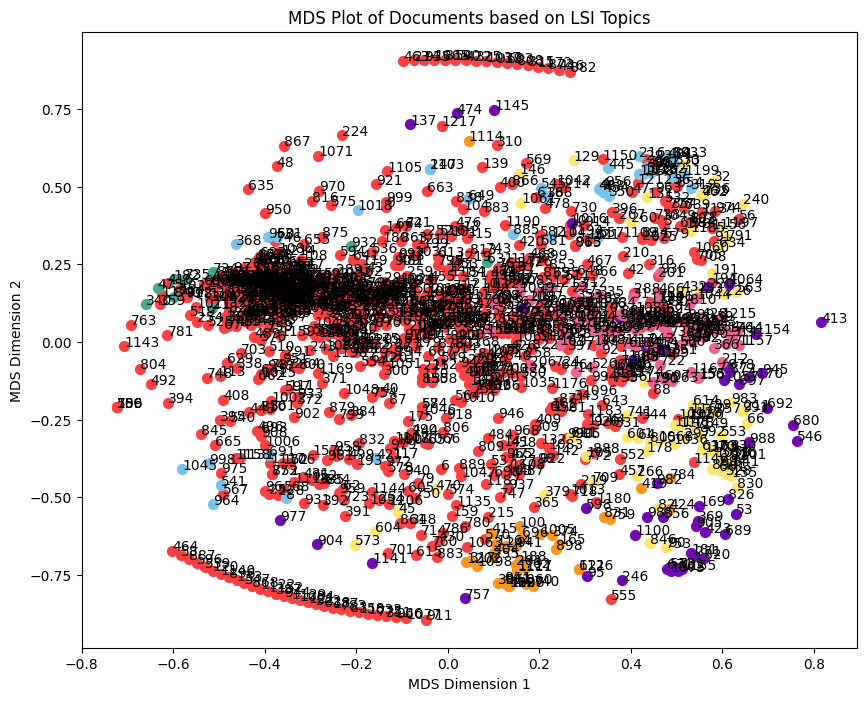

In [ ]:
# Extract document-topic distributions from LSI model
doc_topic_dist = np.zeros((len(corpus_test_tfidf), lsi_tfidf_model.num_topics))

for i, doc in enumerate(lsi_corpus_tfidf):
    for topic_id, topic_prob in doc:
        doc_topic_dist[i, topic_id] = topic_prob

# Compute cosine similarity matrix between documents
from sklearn.metrics.pairwise import cosine_similarity
doc_similarity = cosine_similarity(doc_topic_dist)

# Apply MDS to reduce dimensionality
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
doc_coords = mds.fit_transform(1 - doc_similarity)  # Use 1 - similarity for distance

topics = np.argmax(doc_topic_dist, axis=1)

# Plotting
plt.figure(figsize=(10, 8))
for topic_id in range(lsi_tfidf_model.num_topics):
  mask = topics == topic_id
  plt.scatter(doc_coords[mask, 0], doc_coords[mask, 1],
              color = list_colors[topic_id], s = 50,
              marker='o', label=f'Topic {topic_id}')

plt.title('MDS Plot of Documents based on LSI Topics')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')

# Optionally label points with document indices or other metadata
for i, txt in enumerate(range(len(doc_coords))):
    plt.annotate(txt, (doc_coords[i, 0], doc_coords[i, 1]))

plt.show()

## Overall Comparison (K-Means vs. Other Models)
K-Means Model focuses on the core functionalities of BSI banking, including basic transactions, BSI specific services, and managing accounts through the mobile app.


Comparison with Topic Extraction Models:
- LDA + BoW Corpus
  - Focus: Strong emphasis on data security concerns, cyberattacks, and account recovery.
  - Difference: Model 1 focuses more on operational banking activities and specific bank services rather than cybersecurity and fraud prevention.
- LDA + BoW and TF-IDF Corpus
  - Focus: Emphasizes mobile banking issues, account management, and customer support interactions.
  - Difference: Model 1 covers a broader spectrum of banking activities beyond just mobile app issues, including basic transactions and specific banking services.
- LSI + BoW Corpus
  - Focus: Highlights basic banking services, customer interactions, and account management.
  - Difference: Model 1 and Model 4 share similarities in covering general banking activities and customer interactions but differ in specific focuses like mobile app issues and regional banking services (Aceh).
- LSI + BoW and TF-IDF Corpus
  - Focus: Concentrates on basic banking transactions, account management, and Syariah banking services.
  - Difference: Model 1 includes a broader scope of banking activities, such as mobile app issues and specific mentions of BSI and other banks, whereas Model 5 focuses more on account management and Syariah banking.


Summary

**The K-Means Model provides a comprehensive view of various banking activities and specific bank services, contrasting with the more specialized focuses of the Text Extraction models on cybersecurity, customer interactions, and regional banking services.**